In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time
import tensorflow as tf
import keras
from tensorflow.examples.tutorials.mnist import input_data

import numpy as np
import matplotlib.pyplot as plt

from models.vae import VAE

plt.style.use('ggplot')
mnist = input_data.read_data_sets("data/japanese/", one_hot = True)


Using TensorFlow backend.


Extracting data/japanese/train-images-idx3-ubyte.gz
Extracting data/japanese/train-labels-idx1-ubyte.gz
Extracting data/japanese/t10k-images-idx3-ubyte.gz
Extracting data/japanese/t10k-labels-idx1-ubyte.gz


#### Instantiate VAE and Saver

In [3]:
vae = VAE(beta=1,batch_size=1000,learning_rate=1e-4,latent_dim=20)
saver = tf.train.Saver()

#### Training

In [4]:
# Initialization
history_loss = []
history_recon = []
history_kl = []
epoch_loss = 0
recon_loss = 0
kl_loss = 0

hm_epochs = 300

In [5]:
for epoch in range(hm_epochs):

    for _ in range(int(mnist.train.num_examples/vae.batch_size)):
        epoch_x, epoch_label = mnist.train.next_batch(vae.batch_size)
        epoch_label = np.argmax(epoch_label,axis=1)
        _, c, recon, kl = vae.fit(np.rint(epoch_x).astype(np.float32))
        epoch_loss += c/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        recon_loss += recon/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        kl_loss += kl/(int(mnist.train.num_examples/vae.batch_size) * vae.batch_size)
        history_loss.append(epoch_loss)
        history_recon.append(recon_loss)
        history_kl.append(kl_loss)
        
    if epoch % 10 is 0:
        print('Epoch', epoch+1, '/',hm_epochs,'; average loss:',epoch_loss, end='; ')
        print('Reconstruction loss : ', recon_loss, end='; ')
        print('KL loss', kl_loss)


Epoch 1 / 300 ; average loss: 455.33720852272734; Reconstruction loss :  455.2725971590908; KL loss 0.06461039185090499
Epoch 11 / 300 ; average loss: 3320.829911079541; Reconstruction loss :  3317.3589670454544; KL loss 3.4709433816302893
Epoch 21 / 300 ; average loss: 5495.090412500002; Reconstruction loss :  5488.7410571022765; KL loss 6.349352661748374
Epoch 31 / 300 ; average loss: 7390.596735227273; Reconstruction loss :  7381.6265201704555; KL loss 8.970211282686762
Epoch 41 / 300 ; average loss: 9180.790150284081; Reconstruction loss :  9169.19656335228; KL loss 11.593582071260983
Epoch 51 / 300 ; average loss: 10903.282772443175; Reconstruction loss :  10888.990169034103; KL loss 14.292599223804489
Epoch 61 / 300 ; average loss: 12573.159315056808; Reconstruction loss :  12556.09735085228; KL loss 17.061962548333984
Epoch 71 / 300 ; average loss: 14200.727746306813; Reconstruction loss :  14180.856357670471; KL loss 19.871387600491282
Epoch 81 / 300 ; average loss: 15793.74363

#### Only use this section if saving model

In [6]:
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = 'saved_models/japanese-vae-'
saved_filename = filename+timestr
saver.save(vae.sess,filename+timestr)

'saved_models/japanese-vae-20190504-232426'

#### Restoring model weights

In [7]:
saver.restore(vae.sess, 'saved_models/japanese-vae-20190504-232426')

INFO:tensorflow:Restoring parameters from saved_models/japanese-vae-20190504-232426


#### Visualise data reconstruction

In [17]:
test_epoch, test_labels = mnist.test.next_batch(vae.batch_size)
x_tst = vae.reconstruct_X(np.rint(test_epoch).astype(np.float32))
test_labels = np.argmax(test_labels,1)

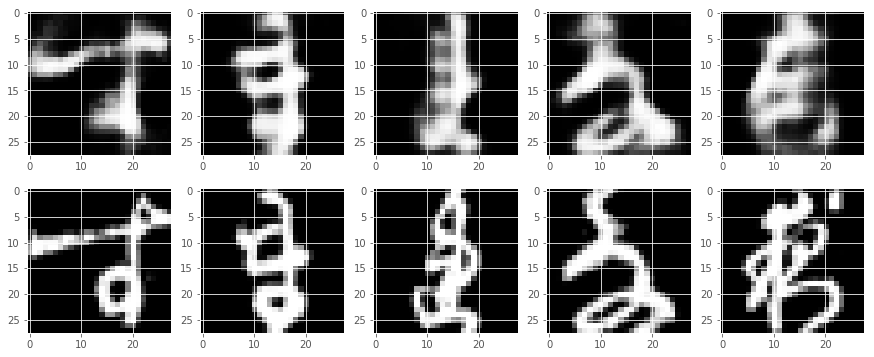

In [18]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
axs = axs.ravel()
n = 0
j = 0

for i in range(n,n+5):
    axs[j].imshow(x_tst[i,:].reshape([28,28]),cmap='gray')
    axs[j+5].imshow(test_epoch[i,:].reshape([28,28]),cmap='gray')
    j += 1
    
plt.show()

#### Visualise latent space

In [10]:
from sklearn import manifold

In [11]:
def draw_digits_latent_space(z_mean_test, test_label):
    plt.scatter(z_mean_test[:,0],z_mean_test[:,1],c=test_label,cmap=plt.cm.get_cmap('jet', 10))
    plt.colorbar()
    plt.show()

In [12]:
test_x, test_label = mnist.test.next_batch(vae.batch_size)
test_label = np.argmax(test_label,axis=1)
z_mu = vae.get_z_mean(np.rint(test_x).astype(np.float32))
tsne = manifold.TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(z_mu)


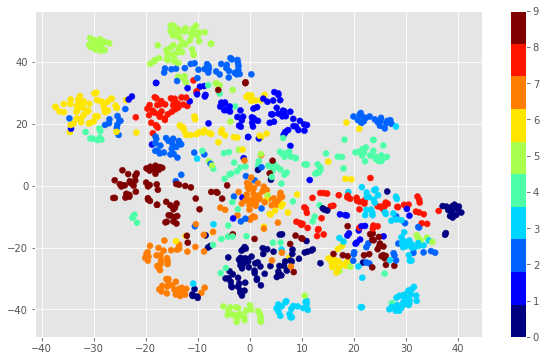

In [13]:
plt.figure(figsize=(10, 6))
draw_digits_latent_space(z_tsne, test_label)
plt.show()

#### Visualize effect of traversing latent space

In [19]:
test_x, test_label = mnist.test.next_batch(vae.batch_size)
z = vae.get_z_mean(test_x)


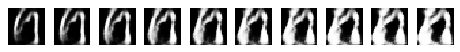

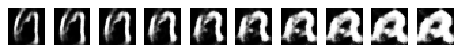

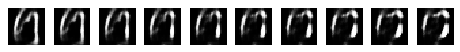

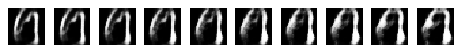

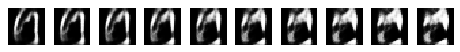

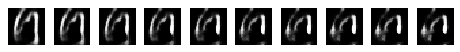

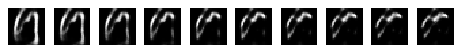

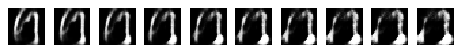

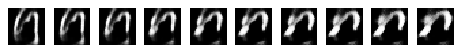

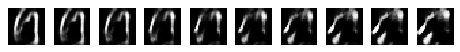

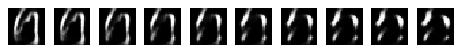

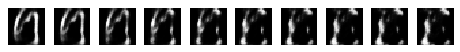

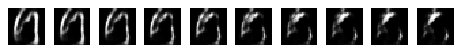

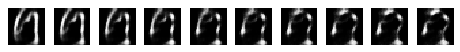

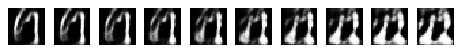

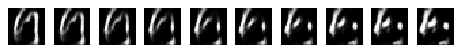

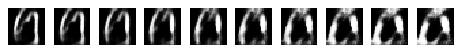

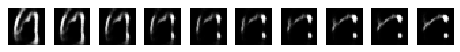

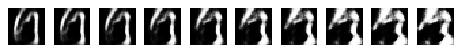

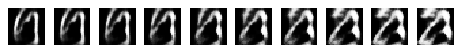

In [20]:
for k in range(0,20):
    z_0 = np.copy(z[0])
    list_of_z = []
    list_of_z.append(z_0)
    dim_observed = k
    z_temp = np.copy(z_0)

    for i in range(0,9):
        z_temp[dim_observed] += 2.0
        list_of_z.append(np.copy(z_temp))
    fig, axs = plt.subplots(1,10, figsize=(8, 2))
    axs = axs.ravel()
    n = 0
    j = 0

    for i in range(0,len(list_of_z)):
        x_gen = vae.generate(np.repeat(list_of_z[i][np.newaxis,:],vae.batch_size,axis=0))
        axs[j].imshow(x_gen[0].reshape([28,28]),cmap='gray')
        axs[j].axes.get_xaxis().set_visible(False)
        axs[j].axes.get_yaxis().set_visible(False)
        j += 1

plt.show()